In [22]:
a="9 9;0 8"
(list(map(lambda j: j.split(),a.split(";"))))

[['9', '9'], ['0', '8']]

Abas identificadas: ['Tarefa', 'LR(1)']


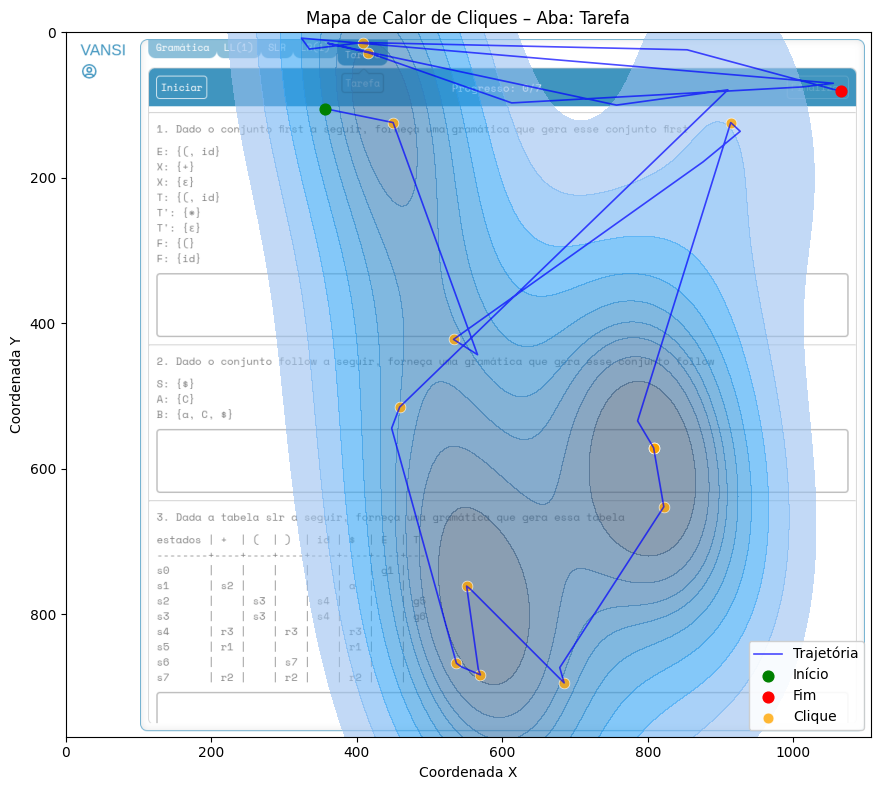

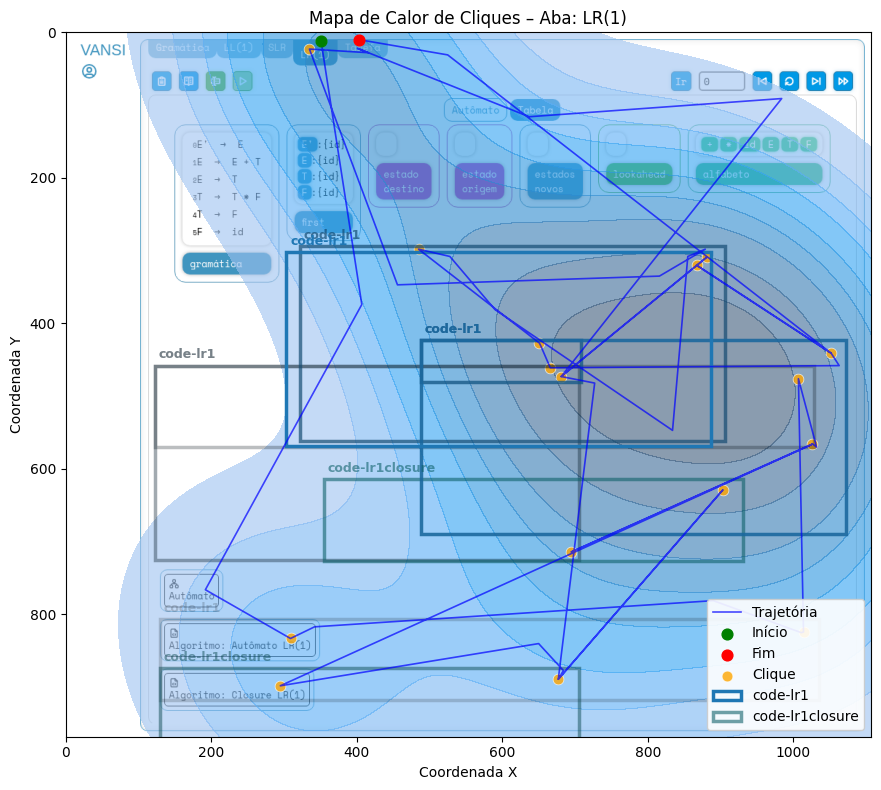

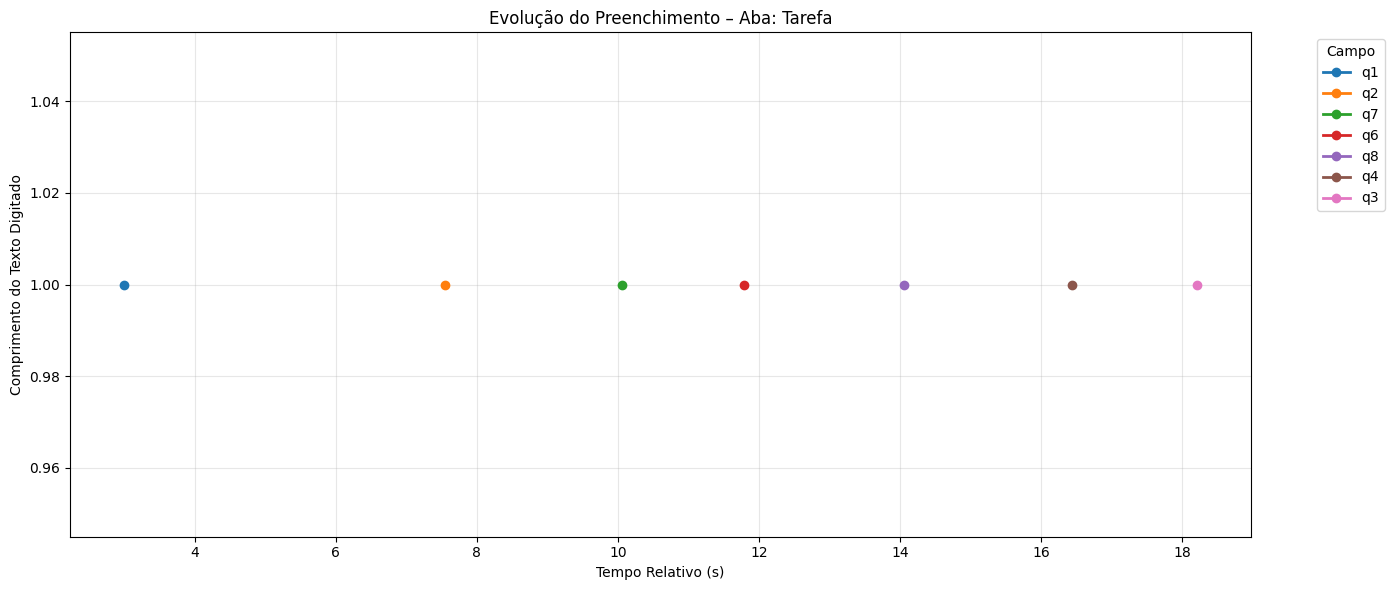

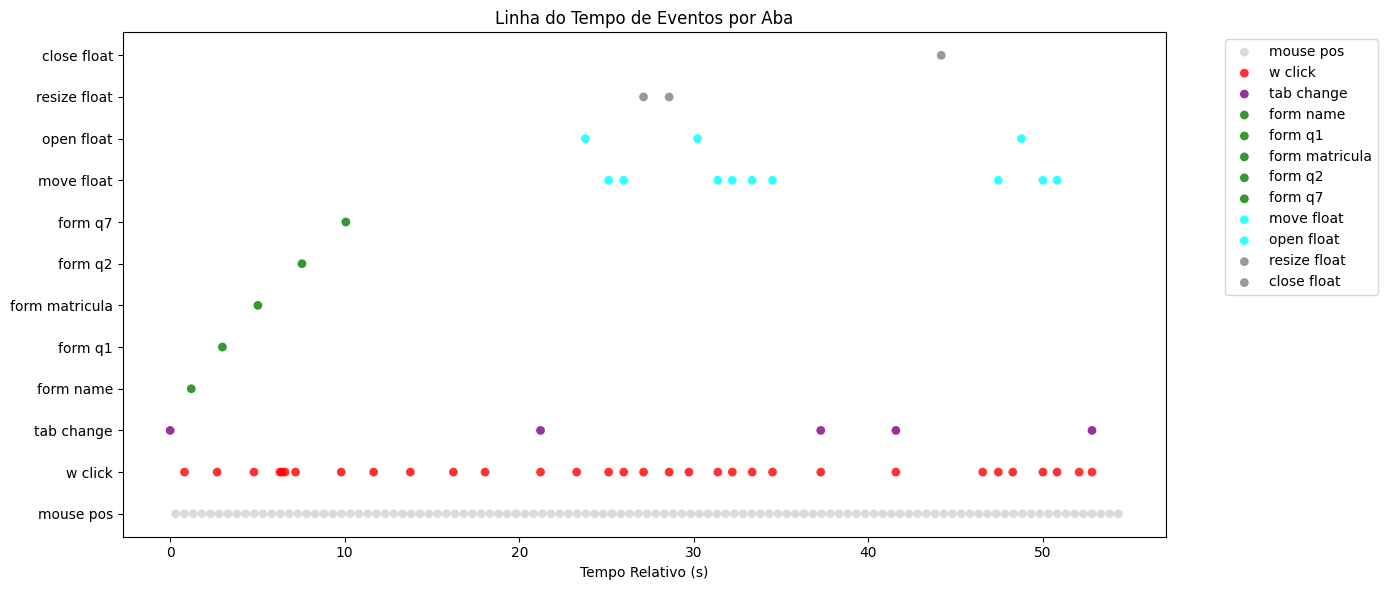


 RESUMO DE ATIVIDADE POR ABA:

Tarefa:
  Duração: 54.3s
  Cliques: 14

LR(1):
  Duração: 31.1s
  Cliques: 18


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import os

def get_windows(df: pd.DataFrame):
    data = []
    window_id = None
    for line_num, line in enumerate(df.values):
        x, y, width, height = np.nan, np.nan, np.nan, np.nan
        try:
            timestamp, event_type, desc, _, active_tab = line
            desc=desc.strip()
            
            if event_type == 'open float':
                id_part, nums = desc.split(';', 1)
                window_id = id_part.strip()
                x, y, width, height = [float(i) for i in np.concat(list(map(lambda j: j.split(), nums.split(";"))))]

            elif event_type == 'move float' or event_type=="resize float":
                if desc.startswith('end'):
                    _, nums = desc.split(';', 1)
                    x, y, width, height = [float(i) for i in np.concat(list(map(lambda j: j.split(), nums.split(";"))))]
                else:
                    _, window_id = desc.split(';')
        
            elif event_type == 'close float':
                window_id = desc.strip()

            data.append({
                'timestamp': timestamp,
                'type': event_type,
                'active_tab': active_tab,
                'window_id': window_id,
                'x': x,
                'y': y,
                'width': width,
                'height': height
            })

        except Exception as e:
            print(f"Error parsing line {line_num}: {line} -> {e}")
            continue
    df = pd.DataFrame(data)
    return df[(~df['x'].isna())]

file_path = "log.txt"
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])

def parse_mouse_desc(desc):
    if ';' not in desc:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])
    mouse_str, win_str = desc.split(';')
    try:
        mx, my = map(int, mouse_str.split())
        wx, wy = map(int, win_str.split())
        return pd.Series([mx, my, wx, wy])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])

mouse_events = df[df['type'].isin(['mouse pos', 'w click'])].copy()
parsed = mouse_events['desc'].apply(parse_mouse_desc)
mouse_events[['mouse_x', 'mouse_y', 'win_width', 'win_height']] = parsed
mouse_events.dropna(subset=['mouse_x', 'mouse_y', 'win_width', 'win_height'], inplace=True)
mouse_events['mouse_x'] = mouse_events['mouse_x'].astype(int)
mouse_events['mouse_y'] = mouse_events['mouse_y'].astype(int)

mouse_events['win_width'] = mouse_events['win_width'].ffill()
mouse_events['win_height'] = mouse_events['win_height'].ffill()

start_time = df['timestamp'].min()
mouse_events['relative_time'] = (mouse_events['timestamp'] - start_time).dt.total_seconds()
df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds()

# ===================================================================
# 1. Extrair mudanças de aba (tab change)
# ===================================================================
tab_changes = df[df['type'] == 'tab change'].copy()
tab_changes['tab_name'] = tab_changes['desc']
tab_changes = tab_changes[['timestamp', 'tab_name']].sort_values('timestamp')

df_sorted = df.sort_values('timestamp')
tabs_list = tab_changes.to_dict('records')

# Função para atribuir aba ativa com base no tempo
def get_active_tab(ts):
    active = "Início"
    for t in tabs_list:
        if ts >= t['timestamp']:
            active = t['tab_name']
        else:
            break
    return active

df['active_tab'] = df['timestamp'].apply(get_active_tab)
mouse_events['active_tab'] = mouse_events['timestamp'].apply(get_active_tab)
df_windows = get_windows(df)
# Atualizar também os eventos de formulário
form_events = df[df['type'].str.startswith('form ')].copy()
form_events['field'] = form_events['type'].apply(lambda x: x.split(' ', 1)[1] if ' ' in x else x)
form_events['input_value'] = form_events['desc'].apply(lambda x: x.split(',', 1)[1] if ',' in x and len(x.split(',',1))>1 else x)
form_events = form_events.dropna(subset=['input_value'])
form_events['active_tab'] = form_events['timestamp'].apply(get_active_tab)

# Separar cliques e movimentos por aba
clicks = mouse_events[mouse_events['type'] == 'w click']
extra_pos = clicks.copy()
extra_pos["type"] = extra_pos['type'].map(lambda _: "mouse pos")

mouse_events = pd.concat([mouse_events, extra_pos]).sort_values("timestamp")
mouse_moves = mouse_events[mouse_events['type'] == 'mouse pos']

tabs_used = [t for t in df['active_tab'].unique()]
print(f"Abas identificadas: {tabs_used}")

# ===================================================================
# GRÁFICO: Heatmap de Cliques por Aba
# ===================================================================
for tab in tabs_used:
    tab_clicks = clicks[clicks['active_tab'] == tab]
    if tab_clicks.empty:
        continue

    tab_moves = mouse_moves[mouse_moves['active_tab'] == tab]
    if len(tab_moves) < 2:
        continue

    sampled = tab_moves.iloc[::1]
    mode_width = int(tab_clicks['win_width'].mode()[0])
    mode_height = int(tab_clicks['win_height'].mode()[0])

    img_path = f'screenshots/{tab}-{mode_width}x{mode_height}.png'
    if not os.path.exists(img_path):
        os.system(f"node screenshot.cjs \"{tab}\" {mode_width} {mode_height}") 
    img = mpimg.imread(img_path)

    img_height, img_width = img.shape[:2]

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.imshow(img, extent=[0, img_width, img_height, 0])  
    
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)  
    ax.set_clip_on(True)

    ax.plot(sampled['mouse_x'], sampled['mouse_y'], color='blue', linewidth=1.2, alpha=0.7, label='Trajetória')
    ax.scatter(sampled.iloc[0]['mouse_x'], sampled.iloc[0]['mouse_y'], color='green', s=60, label='Início', zorder=5)
    ax.scatter(sampled.iloc[-1]['mouse_x'], sampled.iloc[-1]['mouse_y'], color='red', s=60, label='Fim', zorder=5)

    sns.kdeplot(ax=ax,data=tab_clicks, x='mouse_x', y='mouse_y', fill=True, alpha=0.6, thresh=0.1)
    ax.scatter(tab_clicks['mouse_x'], tab_clicks['mouse_y'], color='orange', s=60, alpha=0.8, edgecolor='white', linewidth=0.5, label='Clique')

    sample = df_windows[df_windows['active_tab']==tab]
    window_ids = sample['window_id'].dropna().unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(window_ids)))
    color_map = {wid: colors[i] for i, wid in enumerate(window_ids)}
    lng = len(sample)-1
    i = -1
    for _, row in sample.iterrows():    
        x, y = row['x'], row['y']
        w = row['width'] 
        h = row['height']
        window_id = row['window_id']
        color = color_map.get(window_id, (0.5, 0.5, 0.5))

        lw = 2.5
        i+=1
        p = i/lng
        alpha =( p+0.2)/1.2

        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=lw,
            edgecolor=color*p,
            facecolor='none',
            alpha=alpha,
            label=window_id
        )
        ax.add_patch(rect)
        ax.text(x + 5, y - 10, window_id, fontsize=9, color=np.array(color)*p, weight='bold', alpha=alpha)


    plt.title(f'Mapa de Calor de Cliques – Aba: {tab}')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.xlim(0, img_width)
    plt.ylim(img_height, 0)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=10, framealpha=0.9)

    # ax.axis("off")
    fig.tight_layout()
    plt.show()

# ===================================================================
# GRÁFICO: Evolução do Preenchimento do Formulário por Aba
# ===================================================================
if not form_events.empty:
    q_fields = [f for f in form_events['field'].unique() if 'q' in f.lower()]
    for tab in tabs_used:
        data_tab = form_events[form_events['active_tab'] == tab]
        if data_tab.empty or not any(f in data_tab['field'].values for f in q_fields):
            continue
        plt.figure(figsize=(14, 6))
        for field in q_fields:
            data_field = data_tab[data_tab['field'] == field]
            if data_field.empty:
                continue
            times = data_field['relative_time']
            lengths = [len(v) for v in data_field['input_value']]
            plt.plot(times, lengths, marker='o', label=field, linewidth=2)

        plt.title(f'Evolução do Preenchimento – Aba: {tab}')
        plt.xlabel('Tempo Relativo (s)')
        plt.ylabel('Comprimento do Texto Digitado')
        plt.legend(title="Campo", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# ===================================================================
# GRÁFICO: Linha do Tempo de Eventos por Aba
# ===================================================================
plt.figure(figsize=(14, 6))
for tab in tabs_used:
    data = df[df['active_tab'] == tab]
    types = data['type'].value_counts().head(8).index
    for etype in types:
        subset = data[data['type'] == etype]
        color_map = {
            'w click': 'red',
            'mouse pos': 'lightgray',
            'tab change': 'purple',
            'algorithm change': 'orange',
            'control flow': 'blue',
            'form ': 'green',
            'grab float': 'cyan',
            'open float': 'cyan',
            'move float': 'cyan'
        }
        color = 'gray'
        for k, c in color_map.items():
            if k in etype:
                color = c
                break
        plt.scatter(subset['relative_time'], [etype] * len(subset), color=color, s=40, alpha=0.8, edgecolor='none', label=etype if etype not in plt.gca().get_legend_handles_labels()[1] else "")

plt.yticks(rotation=0)
plt.xlabel('Tempo Relativo (s)')
plt.title('Linha do Tempo de Eventos por Aba')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===================================================================
# RESUMO: Atividade por Aba
# ===================================================================
print("\n RESUMO DE ATIVIDADE POR ABA:")
for tab in tabs_used:
    tab_data = df[df['active_tab'] == tab]

    duration = tab_data['relative_time'].max() - tab_data['relative_time'].min()
    clicks_in_tab = tab_data[tab_data['type'] == 'w click'].shape[0]
    print(f"\n{tab}:")
    print(f"  Duração: {duration:.1f}s")
    print(f"  Cliques: {clicks_in_tab}")
    

In [ ]:
import os
for tab, size in pos.groupby(["active_tab", "desc"]).groups.keys():
    x, y = [float(i) for i in size.split(" ")]
    os.system(f"node screenshot.cjs \"{tab}\" {x} {y}")  
    print(tab,x, y)

Arguments passed: [ 'LR(1)', '1107.0', '968.0' ]
Screenshot saved!
LR(1) 1107.0 968.0
Arguments passed: [ 'Tarefa', '1107.0', '968.0' ]
Screenshot saved!
Tarefa 1107.0 968.0
